# A community based test

## Preliminaries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import datetime
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import remove_shared_ax, rotate_labels
from graspologic.utils import binarize
from matplotlib.transforms import Bbox
from myst_nb import glue
from pkg.data import (
    load_maggot_graph,
    load_network_palette,
    load_node_palette,
    select_nice_nodes,
)
from pkg.io import savefig
from pkg.perturb import remove_edges
from pkg.plot import set_theme
from pkg.stats import stochastic_block_test
from seaborn.utils import relative_luminance
from tqdm import tqdm

DISPLAY_FIGS = True


def gluefig(name, fig, **kwargs):
    foldername = "sbm_test"
    savefig(name, foldername=foldername, **kwargs)

    glue("fig:" + name, fig, display=False)

    if not DISPLAY_FIGS:
        plt.close()

### Load and process data

In [2]:

t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
neutral_color = sns.color_palette("Set2")[2]

GROUP_KEY = "simple_group"

mg = load_maggot_graph()
mg = select_nice_nodes(mg)
left_mg, right_mg = mg.bisect(lcc=True)
left_nodes = left_mg.nodes
right_nodes = right_mg.nodes

left_adj = left_mg.sum.adj
right_adj = right_mg.sum.adj
left_adj = binarize(left_adj)
right_adj = binarize(right_adj)

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

Removed 12 nodes when taking the largest connected component.
Removed 38 nodes when removing pendants.
Removed 0 nodes when taking the largest connected component.


## The stochastic block model 2-sample test

### Run the test

In [3]:

stat, pvalue, misc = stochastic_block_test(
    left_adj, right_adj, labels1=left_labels, labels2=right_labels, method="fisher"
)
glue("uncorrected_pvalue", pvalue, display=False)

### Plot the results

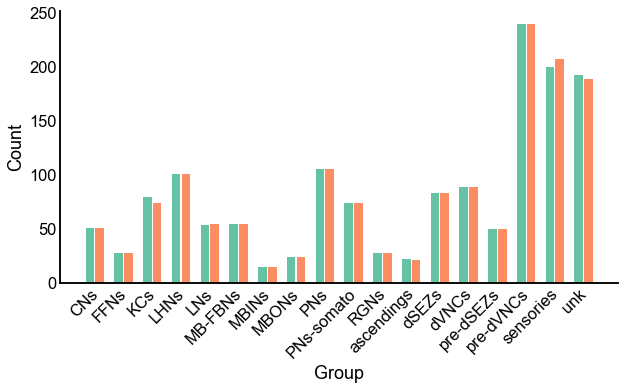

In [4]:
set_theme(font_scale=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

group_counts_left = misc["group_counts1"]
group_counts_right = misc["group_counts2"]

for i in range(len(group_counts_left)):
    ax.bar(i - 0.17, group_counts_left[i], width=0.3, color=network_palette["Left"])
    ax.bar(i + 0.17, group_counts_right[i], width=0.3, color=network_palette["Right"])

rotate_labels(ax)
ax.set(
    ylabel="Count",
    xlabel="Group",
    xticks=np.arange(len(group_counts_left)) + 0.2,
    xticklabels=group_counts_left.index,
)
gluefig("group-counts", fig)


```{glue:figure} fig:group-counts
:name: "fig:group-counts"

The number of neurons in each group in each hemisphere. Note the similarity between
the hemispheres.
```

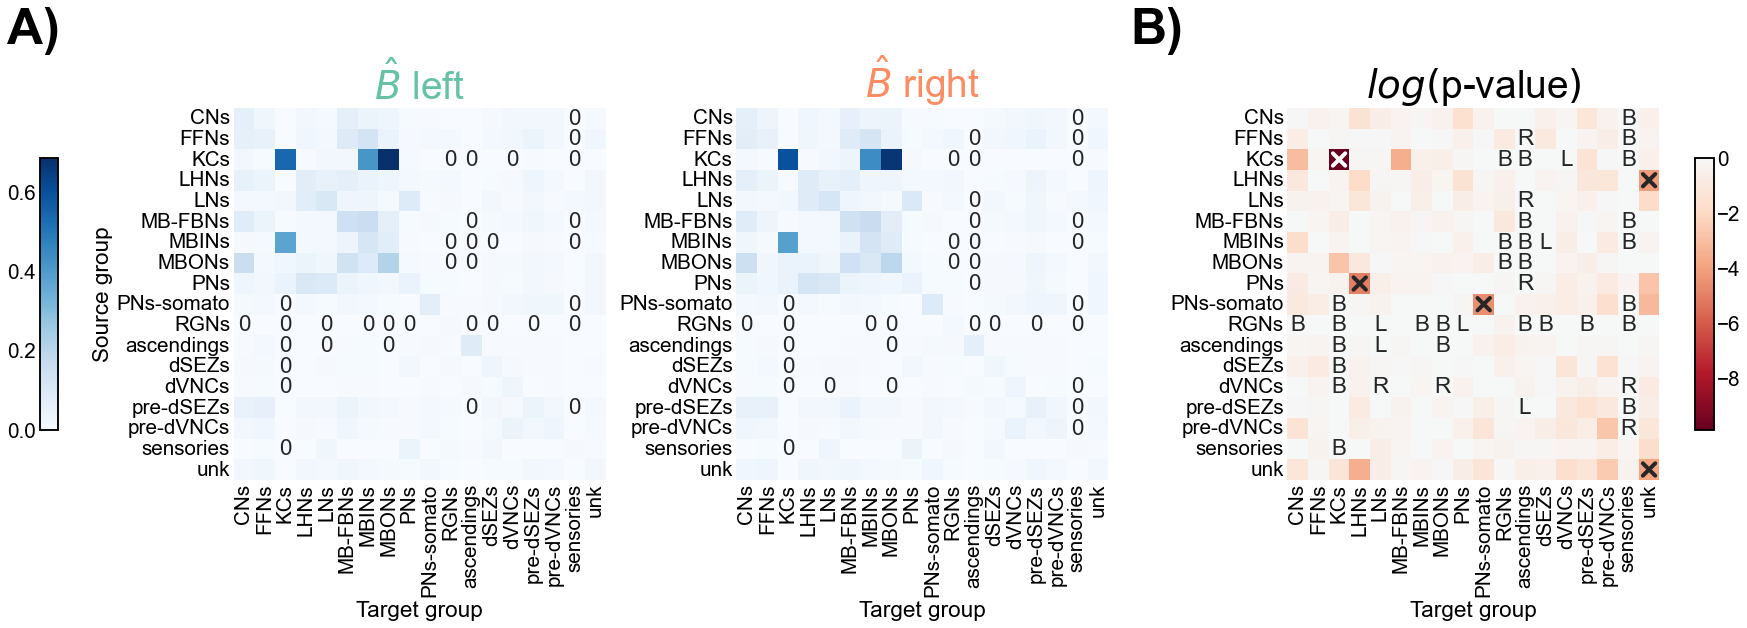

In [5]:


def plot_stochastic_block_test(misc):
    # get values
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_odds"]
    B2 = B2 * null_odds

    index = B1.index
    p_max = max(B1.values.max(), B2.values.max())
    uncorrected_pvalues = misc["uncorrected_pvalues"]
    n_tests = misc["n_tests"]
    K = B1.shape[0]
    alpha = 0.05
    hb_thresh = alpha / n_tests

    # set up plot
    pad = 2
    width_ratios = [0.5, pad + 0.8, 10, pad - 0.4, 10, pad + 0.9, 10, 0.5]
    set_theme(font_scale=1.25)
    fig, axs = plt.subplots(
        1,
        len(width_ratios),
        figsize=(30, 10),
        gridspec_kw=dict(
            width_ratios=width_ratios,
        ),
    )
    left_col = 2
    right_col = 4
    pvalue_col = 6

    heatmap_kws = dict(
        cmap="Blues", square=True, cbar=False, vmax=p_max, fmt="s", xticklabels=True
    )

    # heatmap of left connection probabilities
    annot = np.full((K, K), "")
    annot[B1.values == 0] = 0
    ax = axs[left_col]
    sns.heatmap(B1, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="Source group", xlabel="Target group")
    ax.set_title(r"$\hat{B}$ left", fontsize="xx-large", color=network_palette["Left"])

    # heatmap of right connection probabilities
    annot = np.full((K, K), "")
    annot[B2.values == 0] = 0
    ax = axs[right_col]
    im = sns.heatmap(B2, ax=ax, annot=annot, **heatmap_kws)
    ax.set(ylabel="", xlabel="Target group")
    text = r"$\hat{B}$ right"
    if null_odds != 1:
        text = r"$c$" + text
    ax.set_title(text, fontsize="xx-large", color=network_palette["Right"])

    # handle the colorbars
    # NOTE: did it this way cause the other options weren't playing nice with auto constrain
    # layouts.

    def shrink_axis(ax, scale=0.7):
        pos = ax.get_position()
        mid = (pos.ymax + pos.ymin) / 2
        height = pos.ymax - pos.ymin
        new_pos = Bbox(
            [
                [pos.xmin, mid - scale * 0.5 * height],
                [pos.xmax, mid + scale * 0.5 * height],
            ]
        )
        ax.set_position(new_pos)

    ax = axs[0]
    shrink_axis(ax, scale=0.5)
    _ = fig.colorbar(
        im.get_children()[0],
        cax=ax,
        fraction=1,
        shrink=1,
        ticklocation="left",
    )

    # plot p-values
    ax = axs[pvalue_col]

    colors = im.get_children()[0].get_facecolors()
    significant = uncorrected_pvalues < hb_thresh

    annot = np.full((K, K), "")
    annot[(B1.values == 0) & (B2.values == 0)] = "B"
    annot[(B1.values == 0) & (B2.values != 0)] = "L"
    annot[(B1.values != 0) & (B2.values == 0)] = "R"
    plot_pvalues = np.log10(uncorrected_pvalues)
    plot_pvalues[np.isnan(plot_pvalues)] = 0
    im = sns.heatmap(
        plot_pvalues,
        ax=ax,
        annot=annot,
        cmap="RdBu",
        center=0,
        square=True,
        cbar=False,
        fmt="s",
    )
    ax.set(ylabel="", xlabel="Target group")
    ax.set(xticks=np.arange(K) + 0.5, xticklabels=index)
    ax.set_title(r"$log($p-value$)$", fontsize="xx-large")

    # NOTE: the x's looked bad so I did this super hacky thing...
    pad = 0.2
    for idx, (is_significant, color) in enumerate(
        zip(significant.values.ravel(), colors)
    ):
        if is_significant:
            i, j = np.unravel_index(idx, (K, K))
            # REF: seaborn heatmap
            lum = relative_luminance(color)
            text_color = ".15" if lum > 0.408 else "w"

            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax.plot(xs, ys, color=text_color, linewidth=4)

    # plot colorbar for the pvalue plot
    # NOTE: only did it this way for consistency with the other colorbar
    ax = axs[7]
    shrink_axis(ax, scale=0.5)
    _ = fig.colorbar(
        im.get_children()[0],
        cax=ax,
        fraction=1,
        shrink=1,
        ticklocation="right",
    )

    fig.text(0.11, 0.85, "A)", fontweight="bold", fontsize=50)
    fig.text(0.63, 0.85, "B)", fontweight="bold", fontsize=50)

    # remove dummy axes
    for i in range(len(width_ratios)):
        if not axs[i].has_data():
            axs[i].set_visible(False)

    return fig, axs


fig, axs = plot_stochastic_block_test(misc)
gluefig("sbm-uncorrected", fig)

```{glue:figure} fig:sbm-uncorrected
:name: "fig:sbm-uncorrected"

Comparison of stochastic block model fits for the left and right hemispheres.
**A)** The estimated group-to-group connection probabilities for the left
and right hemispheres appear qualitatively similar. Any estimated
probabilities which are zero (i.e. no edge was present between a given pair of
communities) is indicated explicitly with a "0" in that cell of the matrix. **B)** The
number of neurons in each group is also similar between the left and right hemispheres.
**C)** The p-values for each hypothesis test between individual elements of
the block probability matrices. In other words, each cell represents a test for
whether a given group-to-group connection probability is the same on the left and the
right sides. "X" denotes a significant p-value after Bonferroni-Holm correction,
with $\alpha=0.05$. "B" indicates that a test was not run since the estimated probability
was zero in that cell on both the left and right. "L" indicates this was the case on
the left only, and "R" that it was the case on the right only. These individual
p-values were combined using Fisher's method, resulting in an overall p-value (for the
null hypothesis that the two group connection probability matrices are the same) of
{glue:text}`uncorrected_pvalue:0.2e`.
```

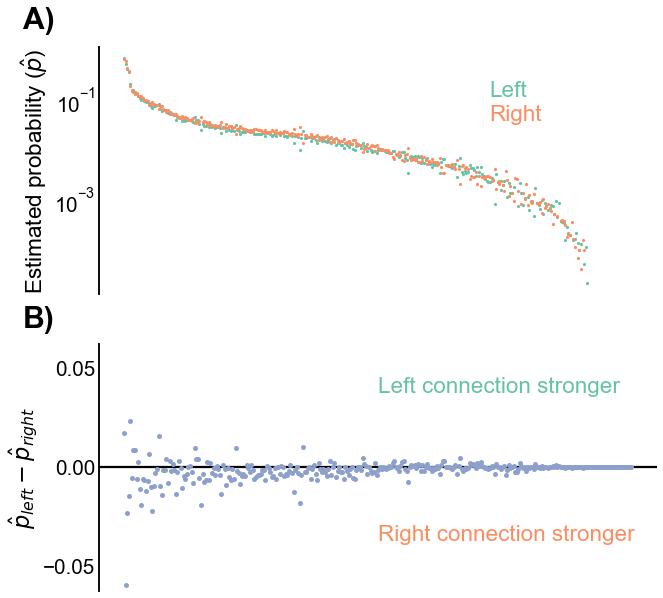

In [6]:


def plot_estimated_probabilities(misc):
    B1 = misc["probabilities1"]
    B2 = misc["probabilities2"]
    null_odds = misc["null_odds"]
    B2 = B2 * null_odds
    B1_ravel = B1.values.ravel()
    B2_ravel = B2.values.ravel()
    arange = np.arange(len(B1_ravel))
    sum_ravel = B1_ravel + B2_ravel
    sort_inds = np.argsort(-sum_ravel)
    B1_ravel = B1_ravel[sort_inds]
    B2_ravel = B2_ravel[sort_inds]

    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax = axs[0]
    sns.scatterplot(
        x=arange,
        y=B1_ravel,
        color=network_palette["Left"],
        ax=ax,
        linewidth=0,
        s=10,
    )
    sns.scatterplot(
        x=arange,
        y=B2_ravel,
        color=network_palette["Right"],
        ax=ax,
        linewidth=0,
        s=10,
    )
    ax.text(
        0.7,
        0.8,
        "Left",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.7,
        0.7,
        "Right",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )
    ax.set_yscale("log")
    ax.set(
        ylabel="Estimated probability " + r"($\hat{p}$)",
        xticks=[],
        xlabel="Sorted group pairs",
    )
    ax.spines["bottom"].set_visible(False)

    ax = axs[1]
    diff = B1_ravel - B2_ravel
    yscale = np.max(np.abs(diff))
    yscale *= 1.05
    sns.scatterplot(
        x=arange, y=diff, ax=ax, linewidth=0, s=25, color=neutral_color, alpha=1
    )
    ax.axhline(0, color="black", zorder=-1)
    ax.spines["bottom"].set_visible(False)
    ax.set(
        xticks=[],
        ylabel=r"$\hat{p}_{left} - \hat{p}_{right}$",
        xlabel="Sorted group pairs",
        ylim=(-yscale, yscale),
    )
    ax.text(
        0.5,
        0.8,
        "Left connection stronger",
        color=network_palette["Left"],
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        0.2,
        "Right connection stronger",
        color=network_palette["Right"],
        transform=ax.transAxes,
    )

    fig.text(0.02, 0.905, "A)", fontweight="bold", fontsize=30)
    fig.text(0.02, 0.49, "B)", fontweight="bold", fontsize=30)

    return fig, ax


fig, ax = plot_estimated_probabilities(misc)
gluefig("probs-uncorrected", fig)

```{glue:figure} fig:probs-uncorrected
:name: "fig:probs-uncorrected"

Comparison of estimated connection probabilities for the left and right hemispheres.
**A)** The estimated group-to-group connection probabilities ($\hat{p}$), sorted by
the mean left/right connection probability. Note the very subtle tendency for the
left probability to be lower than the corresponding one on the right. **B)** The
differences between corresponding group-to-group connection probabilities
($\hat{p}_{left} - \hat{p}_{right}$). The trend of the left connection probabilities
being slightly smaller than the corresponding probability on the right is more
apparent here, as there are more negative than positive values.
```

## Look at the community connections that were significantly different

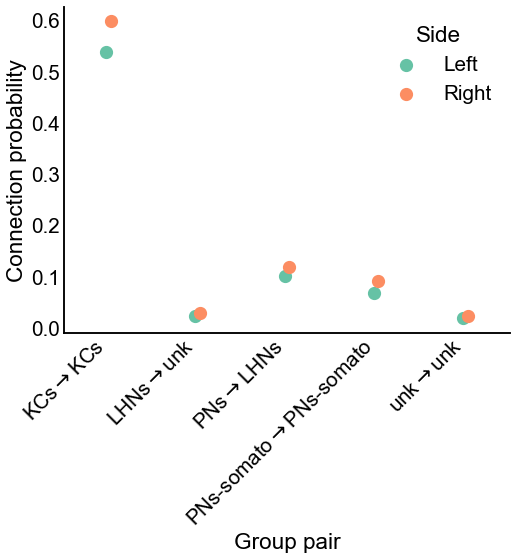

In [7]:
B1 = misc["probabilities1"]
B2 = misc["probabilities2"]
null_odds = misc["null_odds"]
B2 = B2 * null_odds
index = B1.index

uncorrected_pvalues = misc["uncorrected_pvalues"]
n_tests = misc["n_tests"]
K = B1.shape[0]
alpha = 0.05
hb_thresh = alpha / n_tests
significant = uncorrected_pvalues < hb_thresh

row_inds, col_inds = np.nonzero(significant.values)

n_significant = len(row_inds)

rows = []
for row_ind, col_ind in zip(row_inds, col_inds):
    source = index[row_ind]
    target = index[col_ind]
    left_p = B1.loc[source, target]
    right_p = B2.loc[source, target]
    pair = source + r"$\rightarrow$" + target
    rows.append(
        {
            "source": source,
            "target": target,
            "p": left_p,
            "side": "Left",
            "pair": pair,
        }
    )
    rows.append(
        {
            "source": source,
            "target": target,
            "p": right_p,
            "side": "Right",
            "pair": pair,
        }
    )
sig_data = pd.DataFrame(rows)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.pointplot(
    data=sig_data,
    y="p",
    x="pair",
    ax=ax,
    hue="side",
    dodge=True,
    join=False,
    palette=network_palette,
)

ax.get_legend().set_title("Side")
rotate_labels(ax)
ax.set(xlabel="Group pair", ylabel="Connection probability")

gluefig("significant-p-comparison", fig)

```{glue:figure} fig:significant-p-comparison
:name: "fig:significant-p-comparison"

Comparison of estimated group-to-group connection probabilities for the group-pairs
which were significantly different in {numref}`Figure {number} <fig:sbm-uncorrected>`.
In each case, the connection probability on the right hemisphere is higher.
```

In [8]:
# #%% [markdown]
# # ## Resample the right network to make the density the same, rerun the test
# #%%
# n_edges_left = np.count_nonzero(left_adj)
# n_edges_right = np.count_nonzero(right_adj)
# n_left = left_adj.shape[0]
# n_right = right_adj.shape[0]
# density_left = n_edges_left / (n_left ** 2)
# density_right = n_edges_right / (n_right ** 2)

# n_remove = int((density_right - density_left) * (n_right ** 2))

# glue("density_left", density_left, display=False)
# glue("density_right", density_right, display=False)
# glue("n_remove", n_remove, display=False)

# #%%
# rows = []
# n_resamples = 25
# glue("n_resamples", n_resamples, display=False)
# for i in range(n_resamples):
#     subsampled_right_adj = remove_edges(
#         right_adj, effect_size=n_remove, random_seed=rng
#     )
#     stat, pvalue, misc = stochastic_block_test(
#         left_adj,
#         subsampled_right_adj,
#         labels1=left_labels,
#         labels2=right_labels,
#         method="fisher",
#     )
#     rows.append({"stat": stat, "pvalue": pvalue, "misc": misc, "resample": i})

# resample_results = pd.DataFrame(rows)

# #%% [markdown]
# # ### Plot the p-values for the corrected tests
# #%%
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.histplot(data=resample_results, x="pvalue", ax=ax)
# ax.set(xlabel="p-value", ylabel="", yticks=[])
# ax.spines["left"].set_visible(False)

# glue("fig_pvalues_corrected", fig, display=False)
# stashfig("p-values-post-correction")
# plt.close()

# mean_resample_pvalue = np.mean(resample_results["pvalue"])
# median_resample_pvalue = np.median(resample_results["pvalue"])

# #%% [markdown]
# # ```{glue:figure} fig_pvalues_corrected
# # :name: "fig-pvalues-corrected"
# #
# # Histogram of p-values after a correction for network density. For the observed networks
# # the left hemisphere has a density of {glue:text}`density_left:0.4f`, and the right hemisphere has
# # a density of {glue:text}`density_right:0.4f`. Here, we randomly removed exactly {glue:text}`n_remove`
# # edges from the right hemisphere network, which makes the density of the right network
# # match that of the left hemisphere network. Then, we re-ran the stochastic block model testing
# # procedure from {numref}`Figure {number} <fig-sbm-uncorrected>`. This entire process
# # was repeated {glue:text}`n_resamples` times. The histogram above shows the distribution
# # of p-values for the overall test. Note that the p-values are no longer small, indicating
# # that with this density correction, we now failed to reject our null hypothesis of
# # bilateral symmetry under the stochastic block model.
# # ```

# #%%
# null_odds = density_left / density_right
# stat, pvalue, misc = stochastic_block_test(
#     left_adj,
#     right_adj,
#     labels1=left_labels,
#     labels2=right_labels,
#     method="fisher",
#     null_odds=null_odds,
# )
# glue("corrected_pvalue", pvalue, display=False)

# #%%
# fig, axs = plot_stochastic_block_test(misc)
# glue("fig_sbm_uncorrected", fig, display=False)
# stashfig("SBM-left-right-comparison")
# # plt.close()

# #%% [markdown]
# # ## Appendix
# #%%

# observed1 = misc["observed1"]
# possible1 = misc["possible1"]

# xs = np.arange(K ** 2)
# ys = observed1.values.ravel()
# ys = np.sort(ys)

# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# sns.lineplot(x=xs, y=ys, ax=ax)
# ax.set(
#     yscale="log",
#     xlabel="Sorted index (group-to-group connections)",
#     ylabel="Number of edges",
# )


# #%% [markdown]
# # ## End
# #%%
# elapsed = time.time() - t0
# delta = datetime.timedelta(seconds=elapsed)
# print("----")
# print(f"Script took {delta}")
# print(f"Completed at {datetime.datetime.now()}")
# print("----")